<a href="https://colab.research.google.com/github/mzignis/dw_matrix_road_signs/blob/master/day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from skimage import color, exposure

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

sns.set()
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
HOME = '/content/drive/My Drive/Colab Notebooks/matrix/dw_matrix_road_signs'
%cd $HOME

/content/drive/My Drive/Colab Notebooks/matrix/dw_matrix_road_signs


In [0]:
train_db = pd.read_pickle('data/train.p')
test_db = pd.read_pickle('data/test.p')

X_train, y_train = train_db['features'], train_db['labels']
X_test, y_test = test_db['features'], test_db['labels']

In [4]:
sign_names = pd.read_csv('data/dw_signnames.csv')
sign_names.head()

,a,b
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
cat_num = y_train.shape[1]

In [7]:
model = Sequential([
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                    Flatten(),
                    Dense(cat_num, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 7s 7ms/step - loss: 8.3129 - accuracy: 0.7755


In [9]:
def get_cnn_v1(input_shape, cat_num, verbose=False):
    model = Sequential([Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                        Flatten(),
                        Dense(cat_num, activation='softmax')])
    if verbose:
        model.summary()

    return model


cnn_v1 = get_cnn_v1(input_shape, cat_num, True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [10]:
def train_model(model, X_train, y_train, params_fit=dict()):

    logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train, 
              y_train,
              batch_size=params_fit.get('batch_size', 128),
              epochs=params_fit.get('epochs', 5),
              verbose=params_fit.get('verbose', 1),
              validation_data=params_fit.get('validation_data', (X_train, y_train)),
              callbacks=[tensorboard_callback])

    return model

model = train_model(cnn_v1, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 34.8533 - accuracy: 0.7418 - val_loss: 0.2700 - val_accuracy: 0.9361
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2294 - accuracy: 0.9458 - val_loss: 0.1448 - val_accuracy: 0.9657
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1448 - accuracy: 0.9660 - val_loss: 0.1307 - val_accuracy: 0.9673
Epoch 4/5
272/272 [==============================] - 6s 24ms/step - loss: 0.1073 - accuracy: 0.9754 - val_loss: 0.0886 - val_accuracy: 0.9785
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0895 - accuracy: 0.9797 - val_loss: 0.0746 - val_accuracy: 0.9826


In [11]:
def get_cnn_v2(input_shape, cat_num, verbose=False):
    model = Sequential([Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                        MaxPool2D(),
                        Dropout(0.5),

                        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                        MaxPool2D(),
                        Dropout(0.3),

                        Flatten(),

                        Dense(1024, activation='relu'),
                        Dropout(0.5),

                        Dense(cat_num, activation='softmax')])
    if verbose:
        model.summary()

    return model


cnn_v2 = get_cnn_v2(input_shape, cat_num, True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [12]:
model = train_model(cnn_v1, X_train, y_train, params_fit={'epochs': 25})

Epoch 1/25
272/272 [==============================] - 6s 24ms/step - loss: 0.1218 - accuracy: 0.9740 - val_loss: 0.0861 - val_accuracy: 0.9799
Epoch 2/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0933 - accuracy: 0.9803 - val_loss: 0.0631 - val_accuracy: 0.9848
Epoch 3/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0904 - accuracy: 0.9808 - val_loss: 0.0464 - val_accuracy: 0.9899
Epoch 4/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0751 - accuracy: 0.9846 - val_loss: 0.0343 - val_accuracy: 0.9919
Epoch 5/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0575 - accuracy: 0.9878 - val_loss: 0.0604 - val_accuracy: 0.9843
Epoch 6/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0645 - accuracy: 0.9870 - val_loss: 0.0179 - val_accuracy: 0.9954
Epoch 7/25
272/272 [==============================] - 6s 23ms/step - loss: 0.0619 - accuracy: 0.9866 - val_loss: 0.1143 - val_accuracy: 0.9738

### DAY 4

In [17]:
labels_dict =  sign_names.to_dict()['b']
labels_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

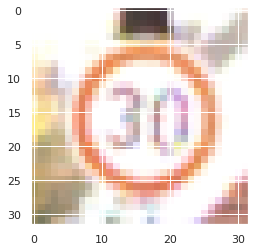

In [13]:
plt.imshow(X_test[400])

In [18]:
y_pred_prob = model.predict(X_test)
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (30km/h)'

In [22]:
def predict(model, X_test, y_test, scoring=accuracy_score):
    y_test_norm = np.argmax(y_test, axis=1)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    return scoring(y_test_norm, y_pred)


predict(model, X_test, y_test)

0.8691609977324263

In [29]:
def train_and_predict(model):
    model_trained = train_model(model, X_train, y_train)
    return predict(model_trained, X_test, y_test)


def get_cnn(input_shape, cat_num):
    model = Sequential([Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
                        MaxPool2D(),
                        Dropout(0.3),

                        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                        MaxPool2D(),
                        Dropout(0.3),

                        Flatten(),

                        Dense(1024, activation='relu'),
                        Dropout(0.3),

                        Dense(1024, activation='relu'),
                        Dropout(0.3),

                        Dense(cat_num, activation='softmax')])
    return model


train_and_predict(get_cnn(input_shape, cat_num))

Epoch 1/5
272/272 [==============================] - 12s 43ms/step - loss: 2.2764 - accuracy: 0.4439 - val_loss: 0.4477 - val_accuracy: 0.8744
Epoch 2/5
272/272 [==============================] - 12s 42ms/step - loss: 0.5083 - accuracy: 0.8453 - val_loss: 0.1034 - val_accuracy: 0.9728
Epoch 3/5
272/272 [==============================] - 12s 43ms/step - loss: 0.2638 - accuracy: 0.9239 - val_loss: 0.0467 - val_accuracy: 0.9884
Epoch 4/5
272/272 [==============================] - 12s 43ms/step - loss: 0.1745 - accuracy: 0.9477 - val_loss: 0.0296 - val_accuracy: 0.9930
Epoch 5/5
272/272 [==============================] - 12s 42ms/step - loss: 0.1309 - accuracy: 0.9622 - val_loss: 0.0384 - val_accuracy: 0.9901


0.9571428571428572

In [0]:
X_train_grey = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_grey = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [32]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    model_trained = train_model(model, X_train, y_train)
    return predict(model_trained, X_test, y_test)


def get_cnn(input_shape, cat_num):
    model = Sequential([Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
                        MaxPool2D(),
                        Dropout(0.3),

                        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                        MaxPool2D(),
                        Dropout(0.3),

                        Flatten(),

                        Dense(1024, activation='relu'),
                        Dropout(0.3),

                        Dense(1024, activation='relu'),
                        Dropout(0.3),

                        Dense(cat_num, activation='softmax')])
    return model


train_and_predict(get_cnn((32, 32, 1), cat_num), X_train_grey, y_train, X_test_grey, y_test)

Epoch 1/5
272/272 [==============================] - 12s 43ms/step - loss: 1.4465 - accuracy: 0.5967 - val_loss: 0.1419 - val_accuracy: 0.9630
Epoch 2/5
272/272 [==============================] - 11s 42ms/step - loss: 0.1738 - accuracy: 0.9463 - val_loss: 0.0402 - val_accuracy: 0.9895
Epoch 3/5
272/272 [==============================] - 11s 42ms/step - loss: 0.0858 - accuracy: 0.9735 - val_loss: 0.0164 - val_accuracy: 0.9959
Epoch 4/5
272/272 [==============================] - 11s 42ms/step - loss: 0.0628 - accuracy: 0.9802 - val_loss: 0.0119 - val_accuracy: 0.9970
Epoch 5/5
272/272 [==============================] - 11s 42ms/step - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.0061 - val_accuracy: 0.9982


0.9755102040816327